In [1]:
from hydra import compose, initialize
from pathlib import Path
import pandas as pd
import numpy as np
from rdkit import Chem
from IPython.display import SVG
import matplotlib.pyplot as plt
from ergochemics.draw import draw_molecule
from collections import defaultdict
from scipy.stats import hmean, gmean # Keep
from ergochemics.mapping import rc_to_nest

with initialize(version_base=None, config_path="../configs/filepaths"):
    filepaths = compose(config_name="filepaths")

In [2]:
# Load

embed_mat = np.load(Path(filepaths.interim_data) / 'decarb' / 'bfm.npy')
examples = pd.read_parquet(Path(filepaths.interim_data) / 'decarb' / 'subgraph_instances.parquet')

In [3]:
# Transform

p1 = embed_mat.sum(axis=0) / embed_mat.shape[0]
sgids = np.argsort(p1)[::-1]
examples['reaction_center'] = examples['reaction_center'].apply(rc_to_nest)
examples.head()

,subgraph_id,rxn_id,smarts,am_smarts,reaction_center,sg_idxs,sep_sg_idxs
0,0,10184,O=C(O)C(O)C(O)C(=O)O>>O=C(O)C(O)CO.O=C=O,[O:10]=[C:8]([OH:9])[CH:1]([OH:2])[CH:3]([OH:4...,"(((3, 1, 2),), ((0,), (0, 1)))",[3],3>>
1,1,10184,O=C(O)C(O)C(O)C(=O)O>>O=C(O)C(O)CO.O=C=O,[O:10]=[C:8]([OH:9])[CH:1]([OH:2])[CH:3]([OH:4...,"(((3, 1, 2),), ((0,), (0, 1)))",[5],5>>
2,2,10184,O=C(O)C(O)C(O)C(=O)O>>O=C(O)C(O)CO.O=C=O,[O:10]=[C:8]([OH:9])[CH:1]([OH:2])[CH:3]([OH:4...,"(((3, 1, 2),), ((0,), (0, 1)))",[8],8>>
3,3,10184,O=C(O)C(O)C(O)C(=O)O>>O=C(O)C(O)CO.O=C=O,[O:10]=[C:8]([OH:9])[CH:1]([OH:2])[CH:3]([OH:4...,"(((3, 1, 2),), ((0,), (0, 1)))",[4],4>>
4,4,10184,O=C(O)C(O)C(O)C(=O)O>>O=C(O)C(O)CO.O=C=O,[O:10]=[C:8]([OH:9])[CH:1]([OH:2])[CH:3]([OH:4...,"(((3, 1, 2),), ((0,), (0, 1)))",[1],1>>


Top subgraphs over all reactions in subset

Subgraph id: 7
Probability: 1.00
Example shown: 10184


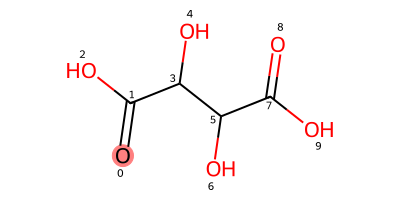

Subgraph id: 345
Probability: 1.00
Example shown: 10184


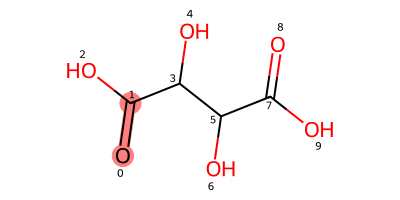

Subgraph id: 4
Probability: 1.00
Example shown: 10184


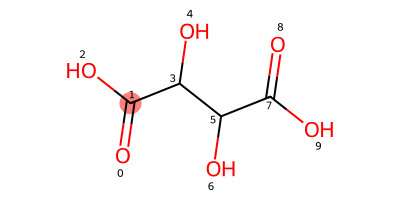

Subgraph id: 348
Probability: 1.00
Example shown: 10184


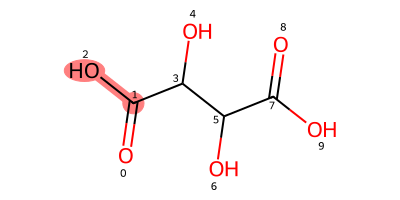

Subgraph id: 6
Probability: 1.00
Example shown: 10184


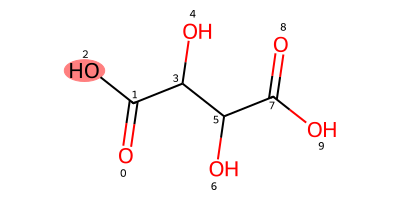

Subgraph id: 11
Probability: 0.40
Example shown: 10213


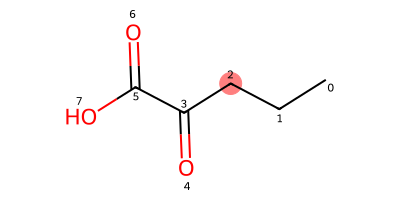

Subgraph id: 0
Probability: 0.38
Example shown: 10184


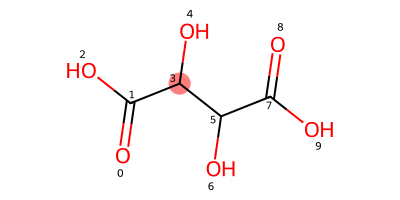

Subgraph id: 766
Probability: 0.38
Example shown: 10184


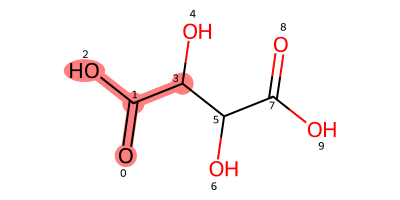

Subgraph id: 359
Probability: 0.34
Example shown: 10634


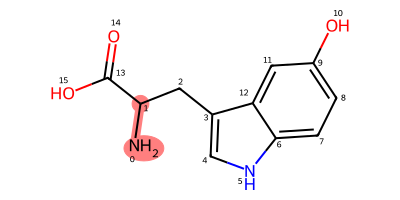

Subgraph id: 29
Probability: 0.34
Example shown: 10634


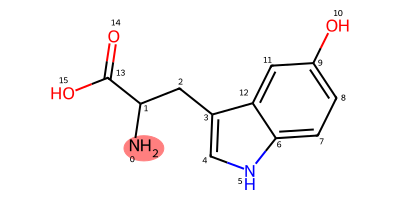

Subgraph id: 1119
Probability: 0.22
Example shown: 10634


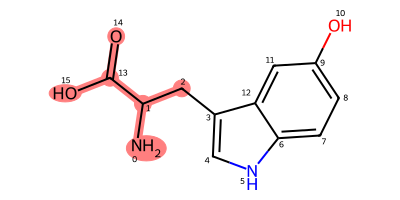

Subgraph id: 783
Probability: 0.22
Example shown: 10634


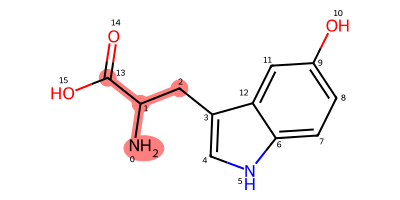

Subgraph id: 8
Probability: 0.21
Example shown: 10184


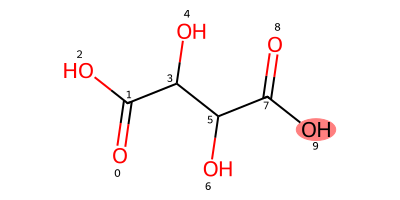

Subgraph id: 12
Probability: 0.21
Example shown: 10213


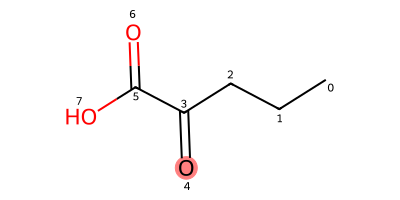

Subgraph id: 14
Probability: 0.20
Example shown: 10213


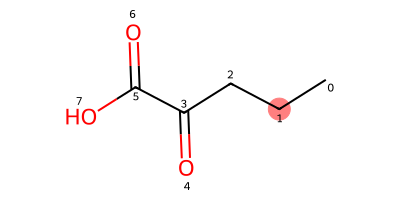

Subgraph id: 10
Probability: 0.17
Example shown: 10213


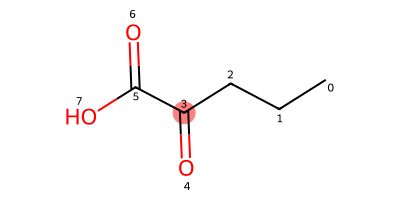

In [4]:
topk = 15

ct = 0
for sgid in sgids:
    if ct > topk:
        break

    # if p1[sgid] == 1:
    #     continue

    ex = examples.loc[examples['subgraph_id'] == sgid].iloc[0]
    sma = ex['smarts']
    rcts = sma.split('>>')[0]
    rcts = Chem.MolFromSmiles(rcts)
    sg_idxs = ex['sg_idxs'].tolist()
    print(f"Subgraph id: {sgid}")
    print(f"Probability: {p1[sgid]:.2f}")
    print(f"Example shown: {ex['rxn_id']}")
    img = draw_molecule(rcts, size=(400, 200), highlight_atoms=sg_idxs, draw_options={"addAtomIndices": True})
    display(SVG(img))

    with open(Path(filepaths.artifacts) / "imgs" / "top_sgs_v0" / f"p_{p1[sgid]*100:.0f}_sg_{sgid}_ex_{ex['rxn_id']}.svg", 'w') as f:
        f.write(img)

    ct += 1
    

Top subgraphs for given reaction

In [5]:
rxn_id = 734
len(examples.loc[examples['rxn_id'] == str(rxn_id)])
examples.loc[examples['rxn_id'] == str(rxn_id)].head()

,subgraph_id,rxn_id,smarts,am_smarts,reaction_center,sg_idxs,sep_sg_idxs
3524,0,734,N=C(N)NCCCC(N)C(=O)O>>N=C(N)NCCCCN.O=C=O,[NH:8]=[C:7]([NH2:9])[NH:6][CH2:5][CH2:4][CH2:...,"(((7, 9, 11),), ((0,), (0, 1)))",[7],7>>
3525,11,734,N=C(N)NCCCC(N)C(=O)O>>N=C(N)NCCCCN.O=C=O,[NH:8]=[C:7]([NH2:9])[NH:6][CH2:5][CH2:4][CH2:...,"(((7, 9, 11),), ((0,), (0, 1)))",[6],6>>
3526,326,734,N=C(N)NCCCC(N)C(=O)O>>N=C(N)NCCCCN.O=C=O,[NH:8]=[C:7]([NH2:9])[NH:6][CH2:5][CH2:4][CH2:...,"(((7, 9, 11),), ((0,), (0, 1)))",[2],2>>
3527,109,734,N=C(N)NCCCC(N)C(=O)O>>N=C(N)NCCCCN.O=C=O,[NH:8]=[C:7]([NH2:9])[NH:6][CH2:5][CH2:4][CH2:...,"(((7, 9, 11),), ((0,), (0, 1)))",[3],3>>
3528,29,734,N=C(N)NCCCC(N)C(=O)O>>N=C(N)NCCCCN.O=C=O,[NH:8]=[C:7]([NH2:9])[NH:6][CH2:5][CH2:4][CH2:...,"(((7, 9, 11),), ((0,), (0, 1)))",[8],8>>


Subgraph id: 345
Probability: 1.00


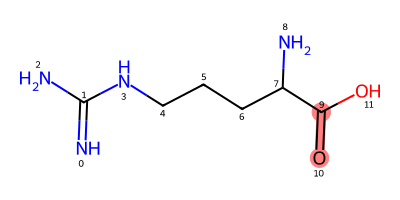

Subgraph id: 7
Probability: 1.00


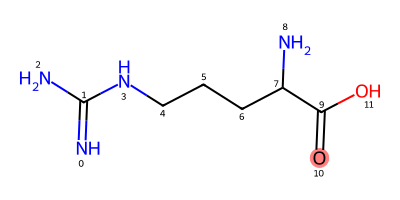

Subgraph id: 6
Probability: 1.00


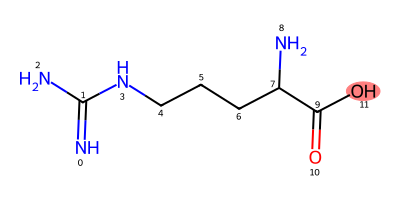

Subgraph id: 4
Probability: 1.00


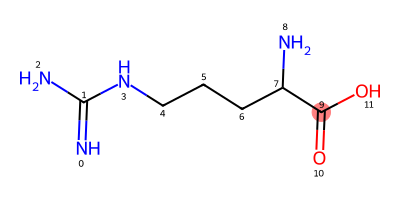

Subgraph id: 348
Probability: 1.00


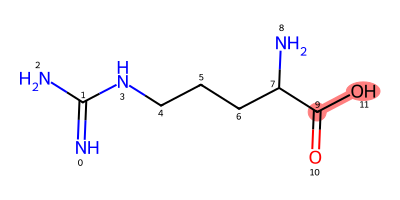

Subgraph id: 11
Probability: 0.40


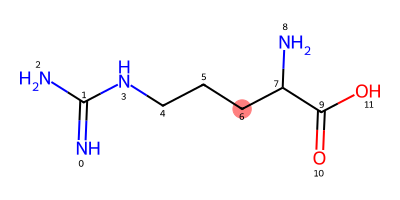

Subgraph id: 0
Probability: 0.38


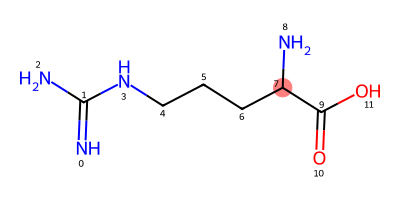

Subgraph id: 766
Probability: 0.38


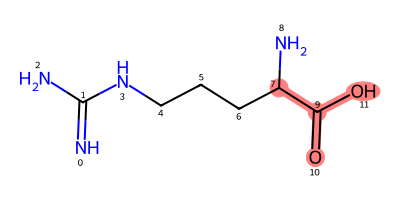

Subgraph id: 29
Probability: 0.34


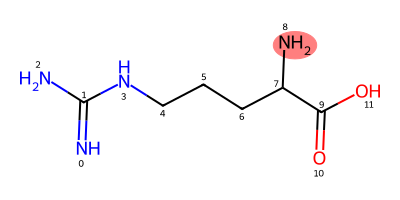

Subgraph id: 359
Probability: 0.34


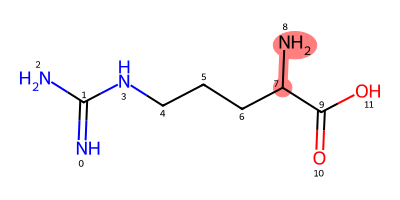

In [6]:
topk = 10
ct = 0
atom_probs = defaultdict(list)
rxn_of_interest = examples.loc[examples['rxn_id'] == str(rxn_id)].sort_values(by='subgraph_id', key=lambda x: p1[x], ascending=False)
for i, subgraph in rxn_of_interest.iterrows():
    sma = subgraph['smarts']
    sgid = subgraph["subgraph_id"]
    sg_idxs = subgraph['sg_idxs'].tolist()
    
    for idx in sg_idxs:
        atom_probs[idx].append(p1[sgid])

    if ct < topk:
        rcts = sma.split('>>')[0]
        rcts = Chem.MolFromSmiles(rcts)
        print(f"Subgraph id: {sgid}")
        print(f"Probability: {p1[sgid]:.2f}")
        img = draw_molecule(rcts, size=(400, 200), highlight_atoms=sg_idxs, draw_options={"addAtomIndices": True})
        display(SVG(img))

        with open(Path(filepaths.artifacts) / "imgs" / "ex_decarb_top_sgs" / f"rxn_{rxn_id}_p_{p1[sgid]*100:.0f}_sg_{sgid}.svg", 'w') as f:
            f.write(img)
    
    
    ct += 1

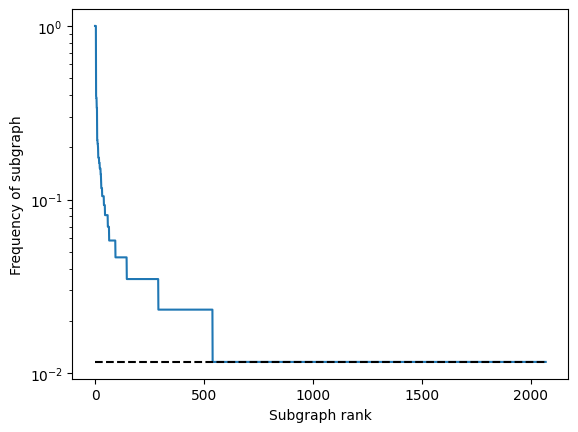

In [7]:
fig, ax = plt.subplots()
ax.plot(np.sort(p1)[::-1])
ax.hlines(1 / embed_mat.shape[0], 0, embed_mat.shape[1], colors='black', linestyles='--')
ax.set_yscale('log')
ax.set_xlabel('Subgraph rank')
ax.set_ylabel('Frequency of subgraph')
plt.show()

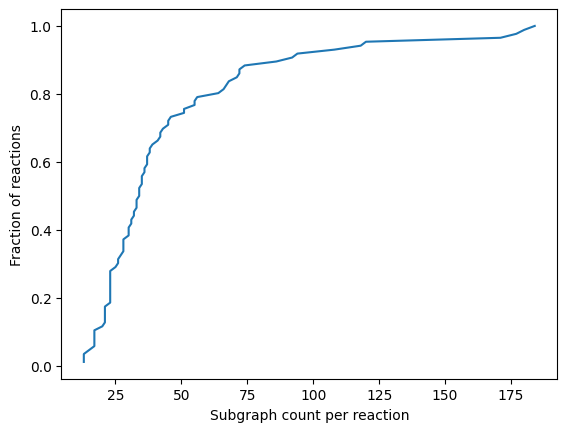

In [8]:
sg_cts = embed_mat.sum(axis=1)
srt_sg_cts = np.sort(sg_cts)
ycdf = np.arange(1, len(srt_sg_cts) + 1) / len(srt_sg_cts)
fig, ax = plt.subplots()
ax.plot(srt_sg_cts, ycdf)
ax.set_xlabel('Subgraph count per reaction')
ax.set_ylabel('Fraction of reactions')
plt.show()


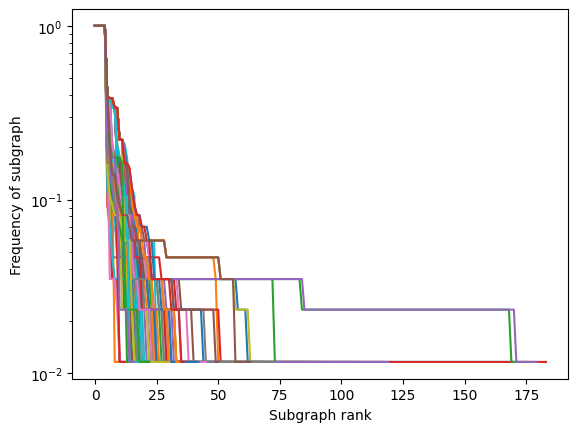

In [9]:
sgids_by_rxn = [np.nonzero(embed_mat[i])[0] for i in range(embed_mat.shape[0])]

fig, ax = plt.subplots()
for row in sgids_by_rxn:
    row_probs = np.sort(p1[row])[::-1]
    ax.plot(row_probs)

ax.set_yscale('log')
ax.set_xlabel('Subgraph rank')
ax.set_ylabel('Frequency of subgraph')
plt.show()

Select atoms apart of union of subgraphs > threshold on frequency

Example shown: 10184


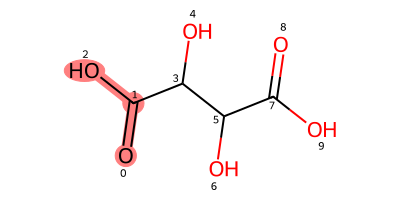

Example shown: 10213


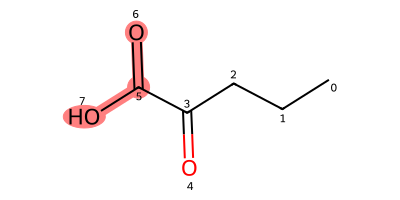

Example shown: 10234


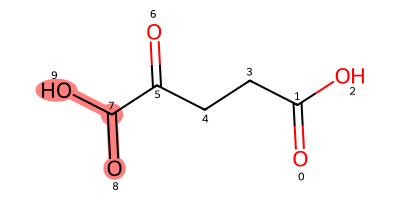

Example shown: 10268


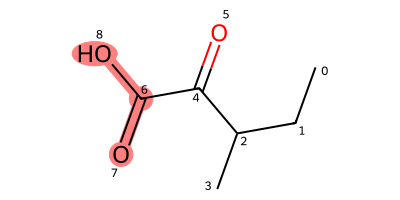

Example shown: 10549


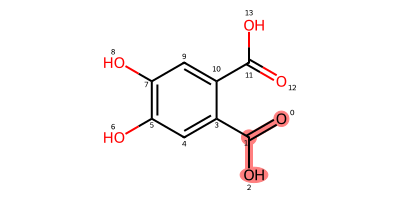

Example shown: 10634


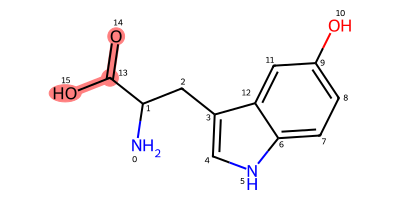

Example shown: 1067


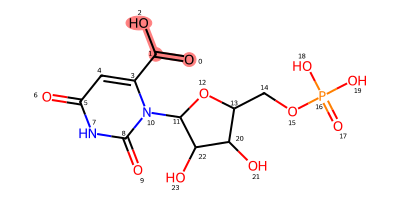

Example shown: 11336


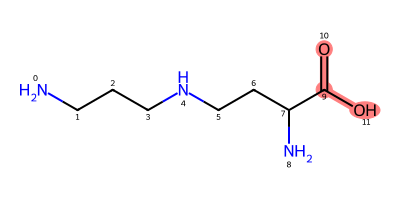

Example shown: 11349


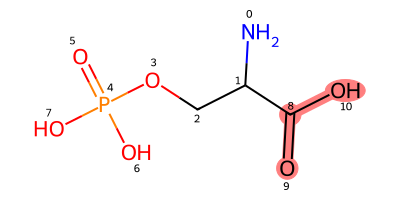

Example shown: 1162


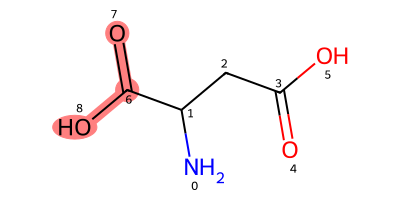

Example shown: 121


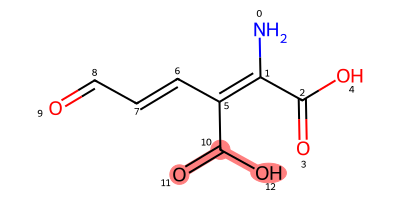

Example shown: 12307


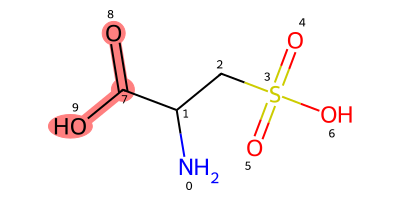

Example shown: 12520


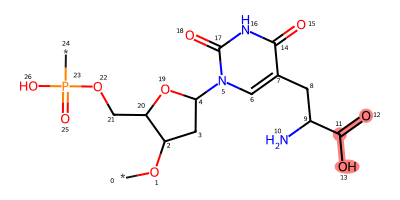

Example shown: 12619


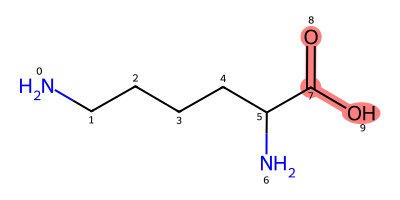

Example shown: 12879


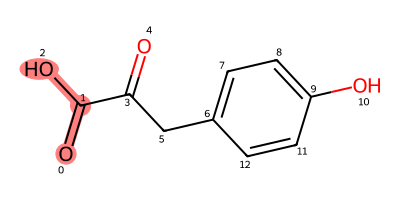

Example shown: 12995


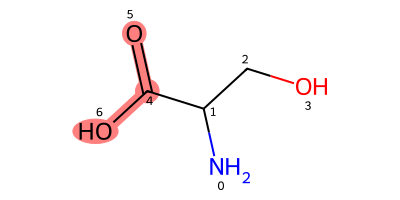

Example shown: 13477


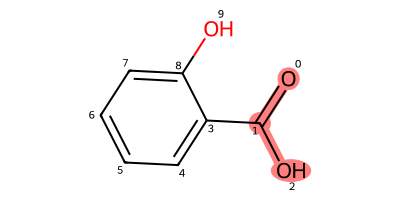

Example shown: 14


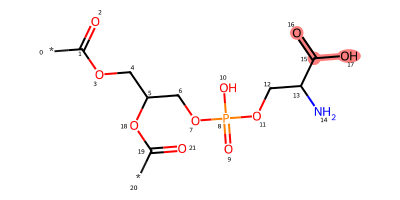

Example shown: 14059


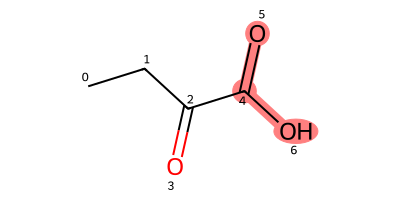

Example shown: 14478


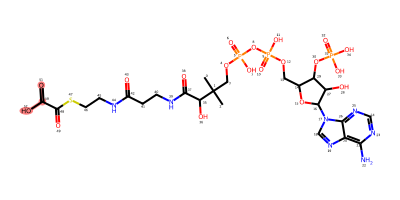

Example shown: 14700


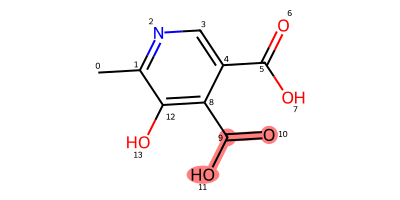

Example shown: 14788


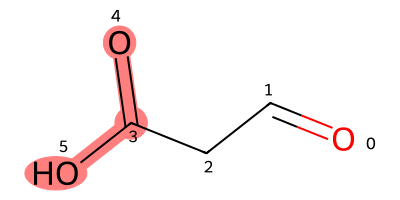

Example shown: 14999


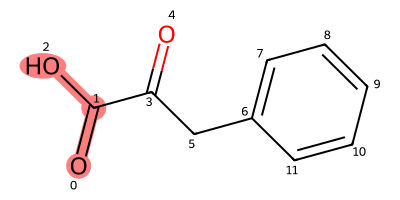

Example shown: 15374


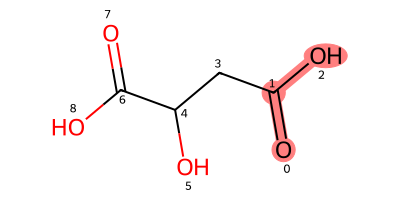

Example shown: 15539


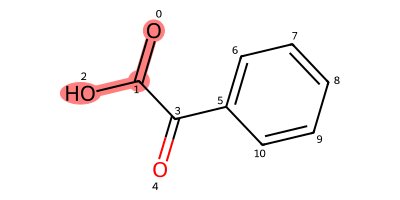

Example shown: 1565


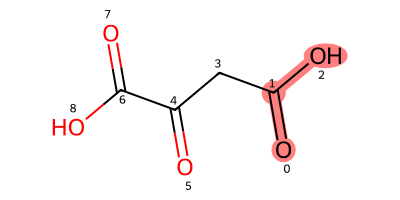

Example shown: 15761


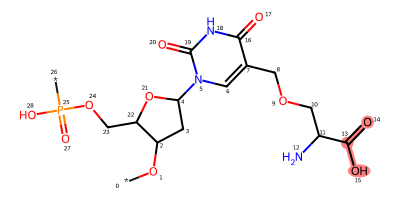

Example shown: 15876


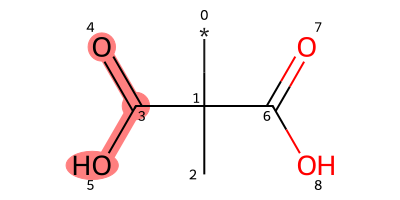

Example shown: 16170


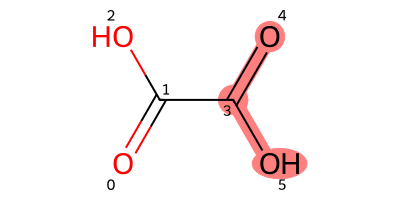

Example shown: 16353


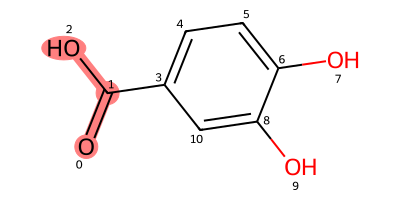

Example shown: 16361


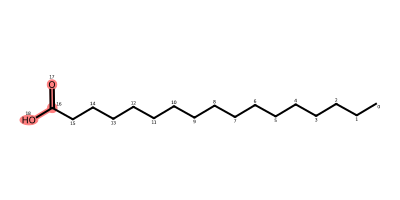

Example shown: 16625


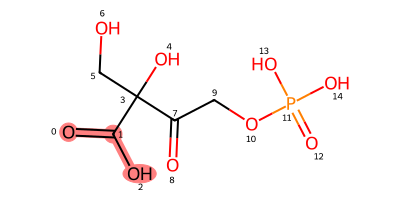

Example shown: 16650


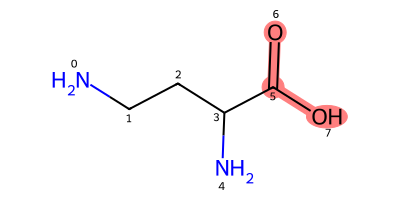

Example shown: 16821


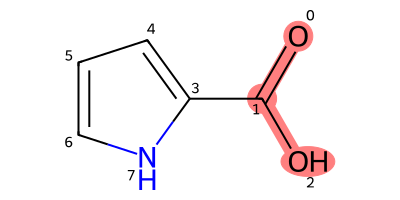

Example shown: 16925


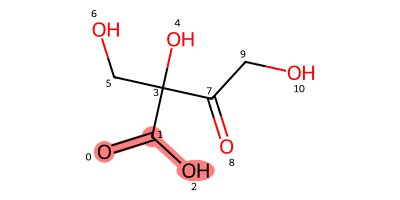

Example shown: 16979


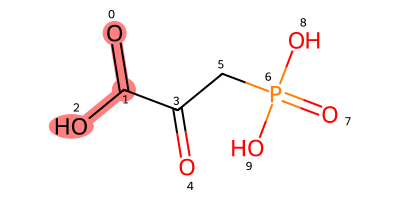

Example shown: 17153


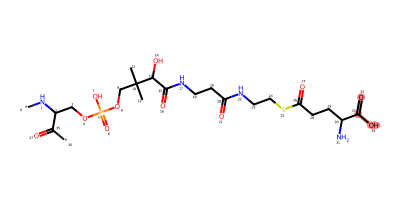

Example shown: 17157


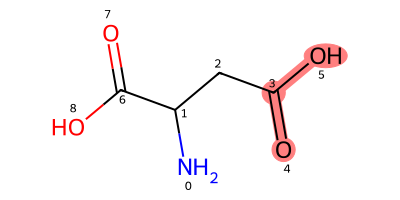

Example shown: 17237


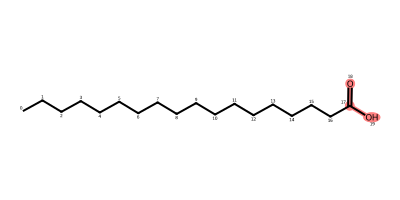

Example shown: 17305


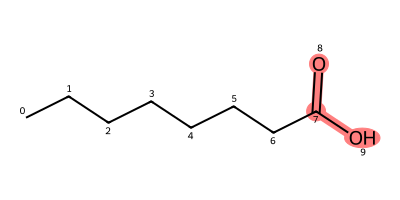

Example shown: 17802


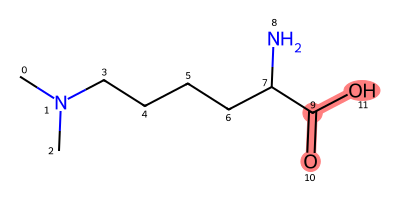

Example shown: 18112


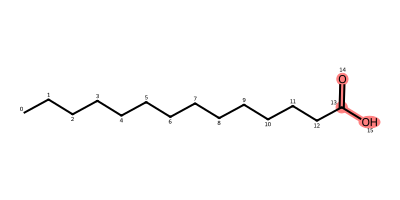

Example shown: 1814


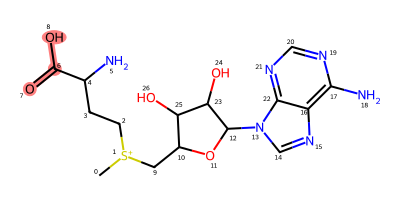

Example shown: 18393


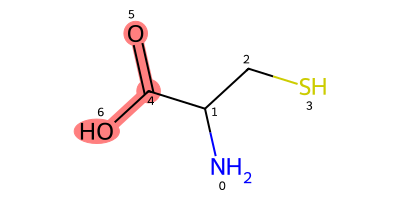

Example shown: 18573


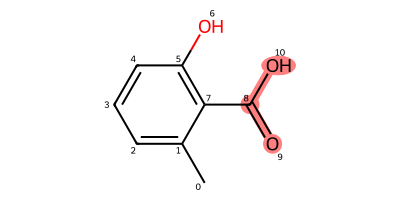

Example shown: 19342


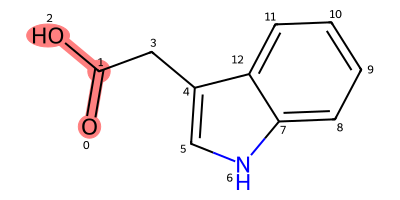

Example shown: 19445


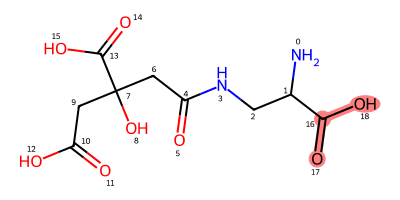

Example shown: 20241


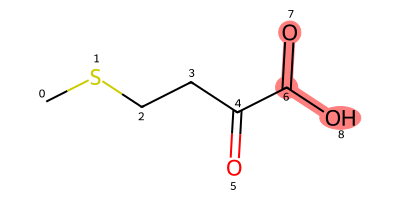

Example shown: 2556


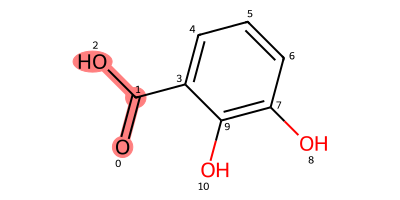

Example shown: 2589


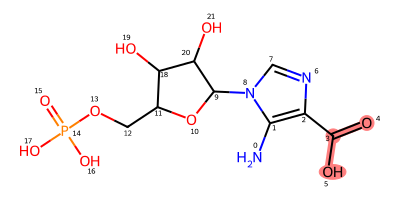

Example shown: 2688


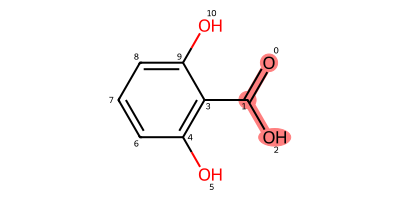

Example shown: 2771


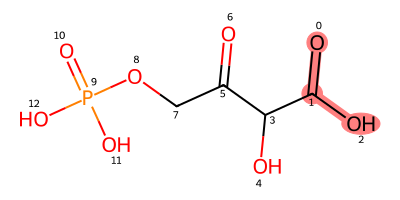

Example shown: 3024


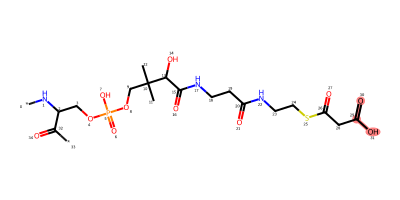

Example shown: 3306


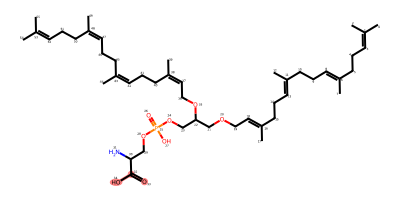

Example shown: 4235


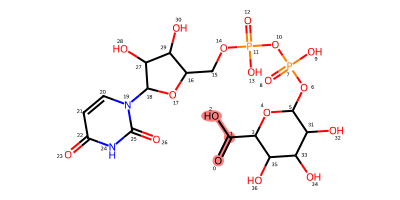

Example shown: 4324


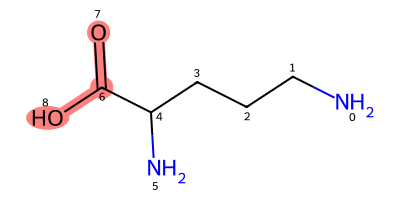

Example shown: 4489


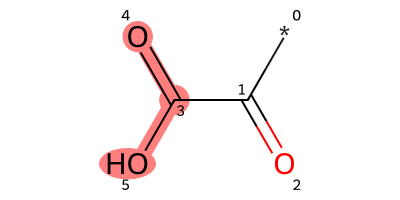

Example shown: 4590


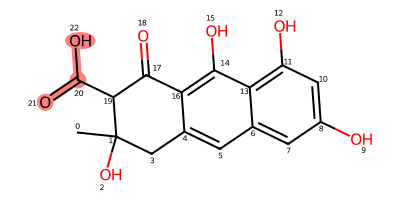

Example shown: 4992


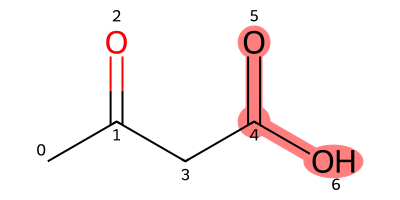

Example shown: 5000


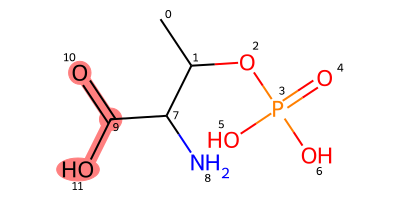

Example shown: 5026


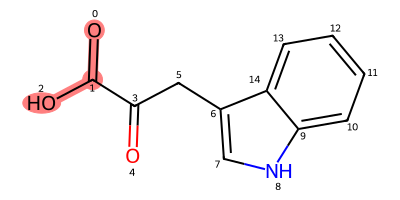

Example shown: 5043


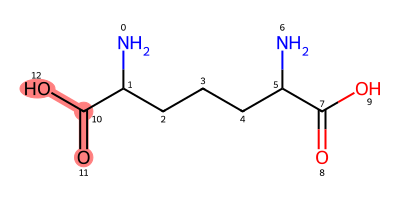

Example shown: 5140


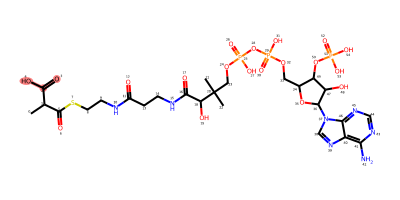

Example shown: 5401


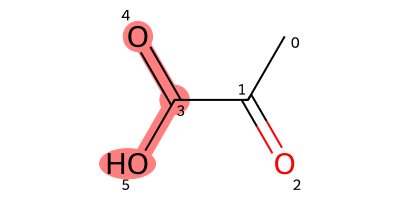

Example shown: 55


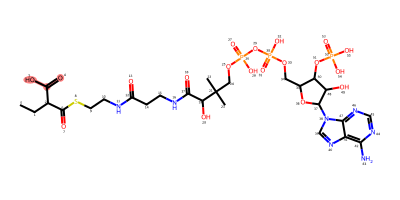

Example shown: 5645


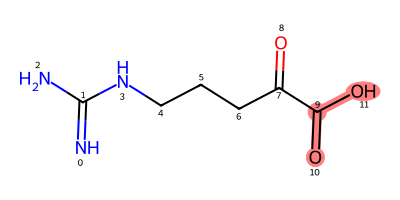

Example shown: 5735


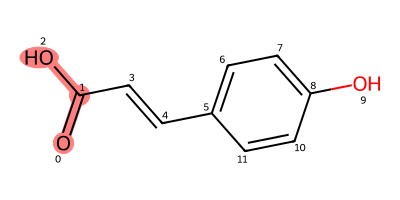

Example shown: 5907


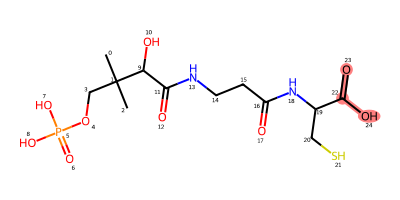

Example shown: 6221


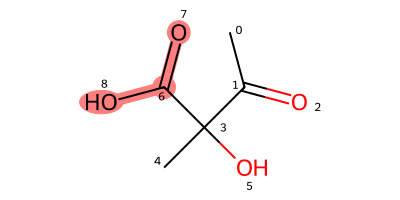

Example shown: 6613


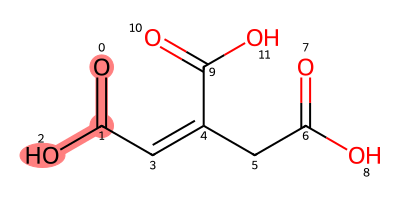

Example shown: 6882


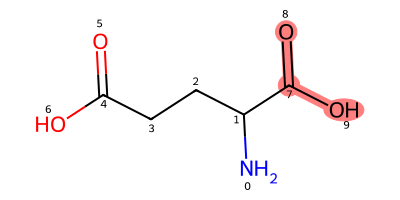

Example shown: 6894


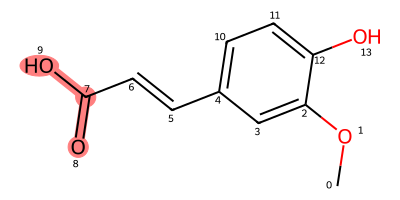

Example shown: 7059


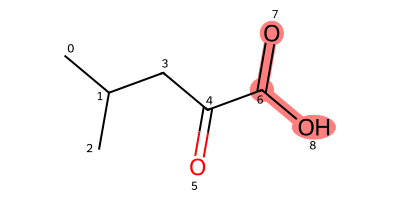

Example shown: 7099


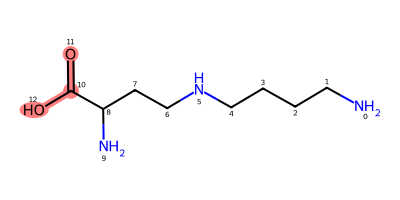

Example shown: 734


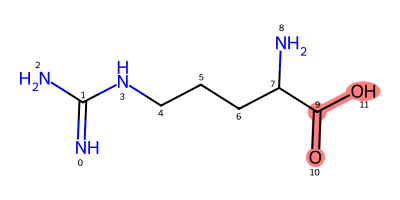

Example shown: 7342


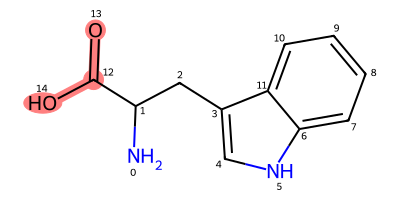

Example shown: 7354


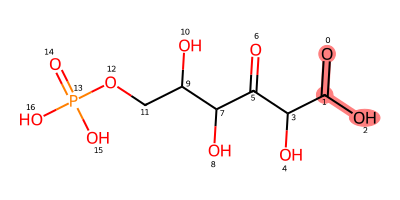

Example shown: 7383


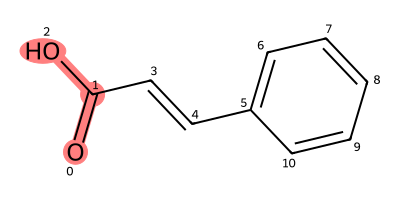

Example shown: 7561


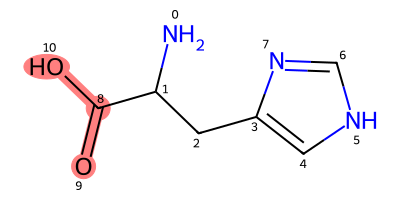

Example shown: 7754


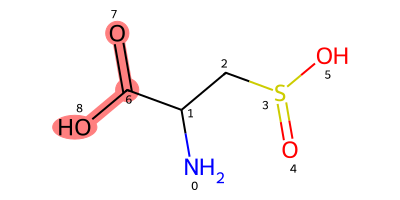

Example shown: 7914


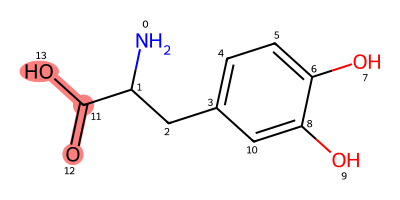

Example shown: 8894


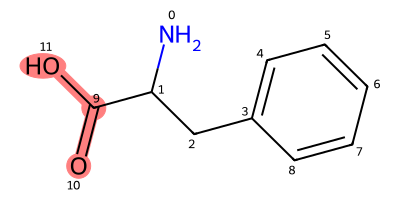

Example shown: 9307


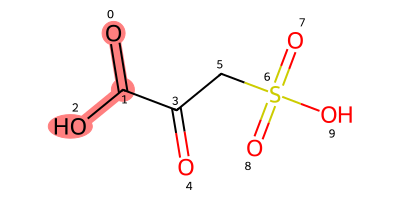

Example shown: 9371


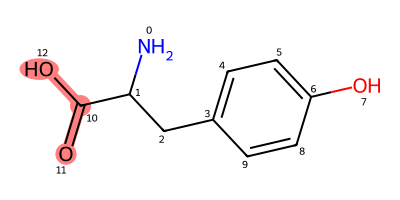

Example shown: 9452


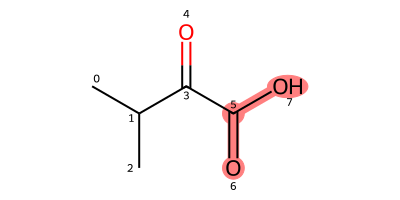

Example shown: 9599


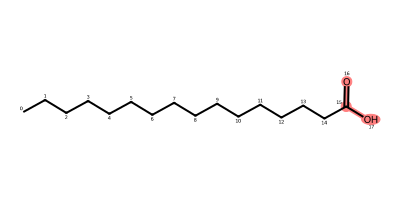

In [18]:
scl = 60
lb = scl / embed_mat.shape[0]

for name, gb in examples.groupby(by="rxn_id"):
    smarts = gb.iloc[0]['smarts']
    rcts = smarts.split('>>')[0]
    rcts = Chem.MolFromSmiles(rcts)
    
    sg_idxs = set()
    for _, row in gb.iterrows():
        if p1[row['subgraph_id']] > lb:
            sg_idxs.update(row['sg_idxs'].tolist())

    print(f"Example shown: {name}")
    display(SVG(draw_molecule(rcts, size=(400, 200), highlight_atoms=sg_idxs, draw_options={"addAtomIndices": True})))

Select by probability of each atom

In [11]:
# aggs = {
#     "arithmetic": np.mean,
#     "harmonic": hmean,
#     "geometric": gmean,
#     "max": np.max
# }

# fig, ax = plt.subplots(ncols=1, nrows=len(aggs), figsize=(7, 9))   
# for i, (agg, func) in enumerate(aggs.items()):
#     for idx, probs in atom_probs.items():
#         ax[i].bar(idx, func(probs))
#     ax[i].set_title(agg)
#     ax[i].set_xticks(np.arange(len(atom_probs)))
#     ax[i].grid()
# plt.tight_layout()
# plt.show()

In [12]:
# all_atom_probs = defaultdict(list)
# for _, row in examples.iterrows():
#     rxn_id = row['rxn_id']
#     sgid = row['subgraph_id']
#     for aidx in row['sg_idxs']:
#         all_atom_probs[f"{rxn_id}_{aidx}"].append(p1[sgid])

# mean_probs = []
# for i, (agg, func) in enumerate(aggs.items()):
#     for idx, probs in all_atom_probs.items():
#         mean_probs.append(func(probs))
#     fig, ax = plt.subplots()
#     ycdf = np.arange(1, len(mean_probs) + 1) / len(mean_probs)
#     ax.plot(np.sort(mean_probs), ycdf)
#     ax.grid()
#     ax.set_title(agg)
#     plt.show()

Visualize single sgid over multiple 

Subgraph id: 730
Probability: 0.02


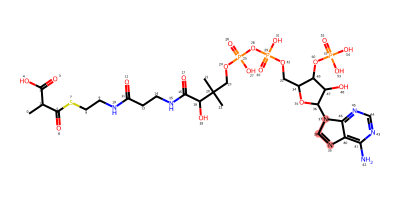

Subgraph id: 730
Probability: 0.02


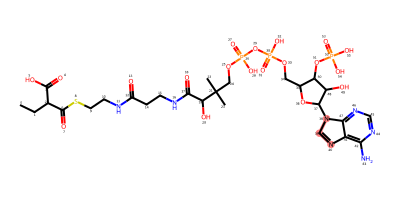

In [13]:
sgid = 730
ct = 0
for i, ex in examples.loc[examples['subgraph_id'] == sgid].iterrows():
    if ct > 4:
        break

    sma = ex['smarts']
    rcts = sma.split('>>')[0]
    rcts = Chem.MolFromSmiles(rcts)
    sg_idxs = ex['sg_idxs'].tolist()
    print(f"Subgraph id: {sgid}")
    print(f"Probability: {p1[sgid]:.2f}")
    display(SVG(draw_molecule(rcts, size=(400, 200), highlight_atoms=sg_idxs, draw_options={"addAtomIndices": True})))
    
    ct +=1

In [14]:
# agg = aggs['max']
# lb = 0.15

# for name, gb in examples.groupby(by="rxn_id"):
#     smarts = gb.iloc[0]['smarts']
#     rcts = smarts.split('>>')[0]
#     rcts = Chem.MolFromSmiles(rcts)
#     aidxs = [atom.GetIdx() for atom in rcts.GetAtoms()]
#     sg_idxs = [elt for elt in aidxs if agg(all_atom_probs[f"{name}_{elt}"]) > lb]
#     print(sorted(sg_idxs, key=lambda x: agg(all_atom_probs[f"{name}_{x}"]), reverse=True))
#     print(f"Example shown: {name}")
#     display(SVG(draw_molecule(rcts, size=(400, 200), highlight_atoms=sg_idxs, draw_options={"addAtomIndices": True})))

In [15]:
import numpy as np

In [16]:
foo = np.arange(10)
bar = np.arange(10)
np.argwhere((foo < 5) & (bar < 3))[0][0]

np.int64(0)